# Import Libraries

In [34]:
!pip install rank_bm25
!pip install bertopic
!pip install sentence-transformers

In [35]:
import pandas as pd
from transformers import AutoTokenizer, pipeline
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from rank_bm25 import BM25Okapi
from bertopic import BERTopic
import numpy as np
from sentence_transformers import SentenceTransformer, util

from google.colab import drive
drive.mount('/content/drive')

device = 0 if torch.cuda.is_available() else -1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load puzzles and survival_reviews

In [36]:
df = pd.read_csv("/content/drive/MyDrive/Youtube_Game_Ads/puzzles_and_survival_reviews_NEWEST.csv")
df.dropna(subset=["content"], inplace=True)
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,65a2b9d4-d120-47ef-9a2d-5117c97e1dd5,Josh Ennis,https://play-lh.googleusercontent.com/a/ACg8oc...,Fun,5,0,7.0.183,2025-03-01 15:33:06,NaN,NaN,7.0.183
1,4dc33531-7942-4df8-bd09-92f927ce1314,Ken Ashford,https://play-lh.googleusercontent.com/a/ACg8oc...,would. be better if CS could.d recover my old ...,4,0,7.0.183,2025-03-01 15:04:42,NaN,NaN,7.0.183
2,5755a637-99b7-4d8c-ad6f-01a28e915190,Ahmed Aslam,https://play-lh.googleusercontent.com/a/ACg8oc...,my game stuck after completion of task unable ...,4,0,7.0.183,2025-03-01 08:56:29,NaN,NaN,7.0.183
3,6766b9da-5f24-4a74-9bca-8a535a3ad2ff,Rashawn Sorrells,https://play-lh.googleusercontent.com/a/ACg8oc...,fun time consuming,4,0,7.0.182,2025-03-01 06:59:36,NaN,NaN,7.0.182
4,a479095b-96a1-4635-8547-2be529b25458,Nicka Alexander,https://play-lh.googleusercontent.com/a/ACg8oc...,it's a mix off good and Abhorrent ! but in the...,2,0,7.0.183,2025-03-01 03:33:17,"Dear player, sorry for making you feel this wa...",2025-03-01 12:23:52,7.0.183
...,...,...,...,...,...,...,...,...,...,...,...
41615,5b609629-fd7e-4615-8f3a-9b639b03300b,Seán Bekx,https://play-lh.googleusercontent.com/a/ACg8oc...,This is just ridiculous....,1,10,NaN,2020-10-03 19:34:39,"Dear player,sorry for your unpleasant experien...",2020-10-04 06:14:08,NaN
41616,4ea2ec41-ee6d-4879-9376-b98a77dee4f1,Eddie,https://play-lh.googleusercontent.com/a/ACg8oc...,Such a trash game....,1,11,5.0.19,2020-10-03 18:50:29,"Dear player,sorry for your unpleasant experien...",2020-10-04 06:14:18,5.0.19
41617,0cee408c-4ede-4667-84c2-a0db93857aca,Rachel Vooght,https://play-lh.googleusercontent.com/a/ACg8oc...,Does the tutorial end who knows? 'I' deafeted ...,1,66,5.0.19,2020-10-03 11:03:06,"Dear player,sorry for your unpleasant experien...",2020-10-04 06:17:45,5.0.19
41618,3ccf4ea6-86a1-4817-9b20-660c70c4911f,Jay Neal,https://play-lh.googleusercontent.com/a-/ALV-U...,Nothing like the ad that brought me here. Seem...,1,72,5.0.19,2020-10-03 08:42:20,"Dear player,sorry for your unpleasant experien...",2020-10-04 06:18:35,5.0.19


# Sentiment Analysis over time

In [37]:
def apply_sentiment_analysis(df, text_column="content", model_name="siebert/sentiment-roberta-large-english", output_file="sentiment_results.csv"):
    """Applies sentiment analysis on a DataFrame column and saves the results."""

    device = 0 if torch.cuda.is_available() else -1
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sentiment_analysis = pipeline("sentiment-analysis", model=model_name, device=device)

    def process_text(text):
        if not isinstance(text, str) or text.strip() == "":
            return "NEUTRAL"

        tokens = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")
        truncated_text = tokenizer.decode(tokens["input_ids"][0], skip_special_tokens=True)

        return sentiment_analysis(truncated_text)[0]['label']

    tqdm.pandas(desc="Processing Sentiment")
    df["sentiment"] = df[text_column].progress_apply(process_text)
    df.to_csv(output_file, index=False)

    return df, df["sentiment"].value_counts()

In [38]:
# If sentiment analysis has not been performed yet, Uncomment the following line
# df_sentiment, sentiment_counts = apply_sentiment_analysis(df, text_column="content", output_file="/content/drive/MyDrive/Youtube_Game_Ads/puzzles_and_survival_reviews_NEWEST_sentiment.csv")

# Else, load the saved results from Google Drive
df_sentiment = pd.read_csv("/content/drive/MyDrive/Youtube_Game_Ads/puzzles_and_survival_reviews_NEWEST_sentiment.csv")

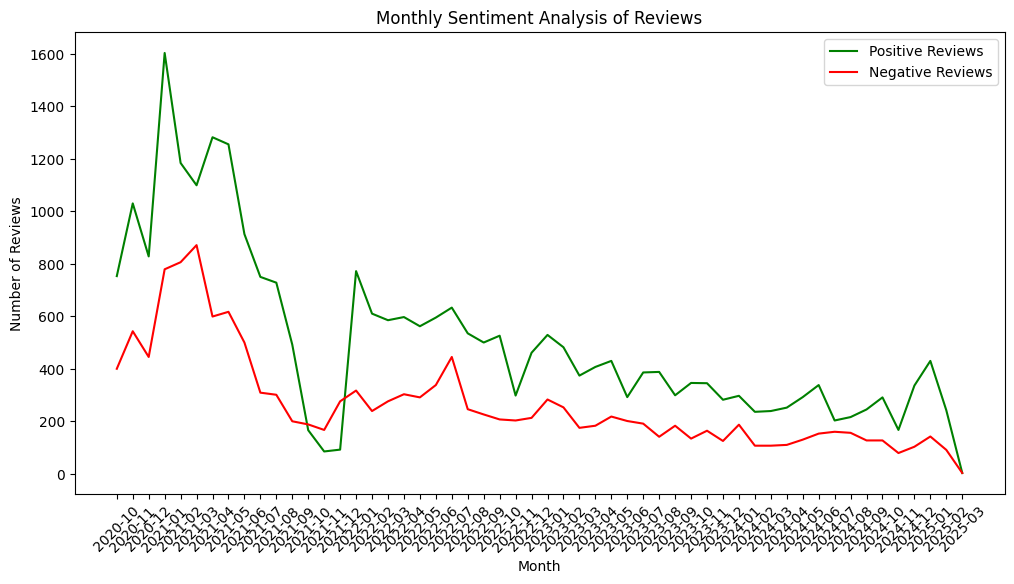

In [39]:
# Plot the sentiment trends over time
df_sentiment['at'] = pd.to_datetime(df_sentiment['at'], errors='coerce')
df_sentiment['Year-Month'] = df_sentiment['at'].dt.to_period('M')

monthly_sentiment = df_sentiment.groupby(['Year-Month', 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
plt.plot(monthly_sentiment.index.astype(str), monthly_sentiment.get('POSITIVE', 0), color='green', label='Positive Reviews')
plt.plot(monthly_sentiment.index.astype(str), monthly_sentiment.get('NEGATIVE', 0), color='red', label='Negative Reviews')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Sentiment Analysis of Reviews')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Categorizing Misleading Ads Using BM25

In [40]:
df = df_sentiment

# Preprocess reviews
df['content'] = df['content'].astype(str).str.lower()
df['at'] = pd.to_datetime(df['at'])
corpus = df["content"].tolist()
tokenized_corpus = [doc.split(" ") for doc in corpus]

# Initialize BM25 model
bm25 = BM25Okapi(tokenized_corpus)

# Define search queries for each misleading ad category
misleading_ad_categories = {
    "Bait-and-Switch": [
        "bait and switch", "not like the ad", "different from ad", "ad lies", "nothing like the ad",
        "fake game ad", "nothing like advertised", "not what i expected",
        "not the game from the ad", "ad was misleading", "i wanted but its"
    ],
    "Fake Incompetence": [
        "fake mistakes", "they fail on purpose",
        "character keep failing", "so dumb in the ad"
    ],
    "Emotional Manipulation": [
        "sad story ad", "made me feel guilty",
        "manipulative ad", "make me feel angry", "make me feel bad"
    ],
    "Sexualized Clickbait": [
        "inappropriate ad", "sexualized ad", "provocative ad",
        "sexism", "offensive", "misogynistic ads", "sexy ad", "women sexualized", "characters are oversexualized"
    ],
    "False Storylines": [
        "story not in the game", "fake storyline", "not the same story",
        "ad tells a different story", "story is completely different"
    ],
    "Borrowed IP": [
        "copied characters", "not the real brand",
        "used characters not in the game", "misleading character use",
        "famous characters"
    ],
    "Exaggerated Difficulty": [
        "game too easy", "boring game", "ad says it's hard but it's not",
        "not a challenge at all", "ad lies about difficulty",
        "not as hard as the ad", "easy game not like ad"
    ]
}

# Store the best match for each review
best_category_results = {review_id: None for review_id in df['reviewId']}

# Iterate through each category and compute scores for all reviews with tqdm progress bar
for category, queries in tqdm(misleading_ad_categories.items(), desc="Processing Categories"):
    for query in tqdm(queries, desc=f"Processing {category}", leave=False):
        tokenized_query = query.lower().split(" ")
        scores = bm25.get_scores(tokenized_query)

        for idx, score in enumerate(scores):
            review_id = df.iloc[idx]['reviewId']
            review = corpus[idx]
            timestamp = df.iloc[idx]['at']

            # If this reviewId gets a higher score for a different category, update it
            if best_category_results[review_id] is None or best_category_results[review_id]["score"] < score:
                best_category_results[review_id] = {
                    "reviewId": review_id,
                    "timestamp": timestamp,
                    "review": review,
                    "category": category,
                    "query": query,
                    "score": score
                }

final_results = [
    (details["reviewId"], details["timestamp"], details["review"], details["category"], details["query"], details["score"])
    for review_id, details in best_category_results.items() if details is not None
]

final_df = pd.DataFrame(final_results, columns=["reviewId", "at", "content", "Category", "Query", "BM25 Score"])

final_df.to_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Categorized_Reviews_with_Highest_Score_new.csv", index=False)

Processing Categories: 100%|██████████| 7/7 [03:49<00:00, 32.78s/it]


In [41]:
final_df = pd.read_csv("/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Categorized_Reviews_with_Highest_Score_new.csv")
final_df

,reviewId,at,content,Category,Query,BM25 Score
0,65a2b9d4-d120-47ef-9a2d-5117c97e1dd5,2025-03-01 15:33:06,fun,Bait-and-Switch,bait and switch,0.000000
1,4dc33531-7942-4df8-bd09-92f927ce1314,2025-03-01 15:04:42,would. be better if cs could.d recover my old ...,Fake Incompetence,they fail on purpose,3.151024
2,5755a637-99b7-4d8c-ad6f-01a28e915190,2025-03-01 08:56:29,my game stuck after completion of task unable ...,Bait-and-Switch,fake game ad,0.514131
3,6766b9da-5f24-4a74-9bca-8a535a3ad2ff,2025-03-01 06:59:36,fun time consuming,Bait-and-Switch,bait and switch,0.000000
4,a479095b-96a1-4635-8547-2be529b25458,2025-03-01 03:33:17,it's a mix off good and abhorrent ! but in the...,Exaggerated Difficulty,ad says it's hard but it's not,4.326223
...,...,...,...,...,...,...
41614,5b609629-fd7e-4615-8f3a-9b639b03300b,2020-10-03 19:34:39,this is just ridiculous....,False Storylines,story is completely different,2.474724
41615,4ea2ec41-ee6d-4879-9376-b98a77dee4f1,2020-10-03 18:50:29,such a trash game....,False Storylines,ad tells a different story,2.112653
41616,0cee408c-4ede-4667-84c2-a0db93857aca,2020-10-03 11:03:06,does the tutorial end who knows? 'i' deafeted ...,Bait-and-Switch,ad was misleading,2.973637
41617,3ccf4ea6-86a1-4817-9b20-660c70c4911f,2020-10-03 08:42:20,nothing like the ad that brought me here. seem...,Bait-and-Switch,nothing like the ad,9.775188


In [42]:
df_final_with_all_reviews = df_sentiment.merge(final_df, on=["reviewId"], how="left")

In [43]:
# Filter by a threshold
threshold = 5.0
filtered_df = df_final_with_all_reviews[df_final_with_all_reviews["BM25 Score"] >= threshold]

filtered_df

,reviewId,userName,userImage,content_x,score,thumbsUpCount,reviewCreatedVersion,at_x,replyContent,repliedAt,appVersion,sentiment,Year-Month,at_y,content_y,Category,Query,BM25 Score
7,18cdbd1a-fd19-481b-aec8-eae0de87e9f9,Arbi,https://play-lh.googleusercontent.com/a-/ALV-U...,garbage fake,1,0,7.0.183,2025-02-28 20:05:26,"Dear player, sorry for making you feel this wa...",2025-03-01 12:23:28,7.0.183,NEGATIVE,2025-02,2025-02-28 20:05:26,garbage fake,Bait-and-Switch,fake game ad,7.987489
9,37dfa740-171f-472d-b143-18e6b88504d7,HukuToc2288,https://play-lh.googleusercontent.com/a/ACg8oc...,nothing like ad or screenshots. i just wanted ...,1,0,NaN,2025-02-28 11:41:03,"Hi, dear player, we are sorry that our game do...",2025-02-28 11:58:44,NaN,NEGATIVE,2025-02,2025-02-28 11:41:03,nothing like ad or screenshots. i just wanted ...,Bait-and-Switch,nothing like the ad,7.591197
12,ea568834-3277-44ad-b271-d2e4417ef910,T. O.,https://play-lh.googleusercontent.com/a-/ALV-U...,why is it so hard to find a mobile game withou...,1,1,7.0.183,2025-02-28 04:38:29,"Hi, dear player, we are sorry that our game do...",2025-02-28 06:17:52,7.0.183,NEGATIVE,2025-02,2025-02-28 04:38:29,why is it so hard to find a mobile game withou...,Exaggerated Difficulty,ad says it's hard but it's not,6.903004
14,c220e696-63bf-407d-8586-b101397948de,tttom inthirath,https://play-lh.googleusercontent.com/a-/ALV-U...,hard hitting,5,0,7.0.182,2025-02-27 18:22:35,NaN,NaN,7.0.182,POSITIVE,2025-02,2025-02-27 18:22:35,hard hitting,Exaggerated Difficulty,ad says it's hard but it's not,7.634596
24,6a24adbe-baf1-4916-985d-7b36f1f751dc,Akari Windsor,https://play-lh.googleusercontent.com/a-/ALV-U...,is it really that hard to make a game that mat...,1,1,7.0.182,2025-02-25 11:35:28,"Hi, dear player, we are sorry that our game do...",2025-02-25 11:56:31,7.0.182,POSITIVE,2025-02,2025-02-25 11:35:28,is it really that hard to make a game that mat...,Exaggerated Difficulty,not as hard as the ad,5.802500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41597,a9379ef4-89aa-49b7-8ceb-36b97ecb8d2b,Keith Fegurgur,https://play-lh.googleusercontent.com/a/ACg8oc...,nothing like the ad,1,9,5.0.19,2020-10-05 13:40:04,"Dear player,sorry for your unpleasant experien...",2020-10-07 04:03:21,5.0.19,NEGATIVE,2020-10,2020-10-05 13:40:04,nothing like the ad,Bait-and-Switch,nothing like the ad,14.577748
41600,c5040454-abf8-4bb4-93fd-afffcf0d38e1,Kelly OConnor,https://play-lh.googleusercontent.com/a/ACg8oc...,nothing like the preview. deleted ten minutes ...,1,9,NaN,2020-10-05 04:03:25,"Dear player,sorry for your unpleasant experien...",2020-10-05 07:02:56,NaN,NEGATIVE,2020-10,2020-10-05 04:03:25,nothing like the preview. deleted ten minutes ...,Bait-and-Switch,nothing like the ad,7.131612
41601,caef180f-2957-4248-9656-34931b19659f,PAUL DndnNZ,https://play-lh.googleusercontent.com/a-/ALV-U...,absolutely nothing like the add #bs,1,8,5.0.19,2020-10-05 03:19:28,"Dear player,sorry for your unpleasant experien...",2020-10-05 07:02:20,5.0.19,NEGATIVE,2020-10,2020-10-05 03:19:28,absolutely nothing like the add #bs,Bait-and-Switch,nothing like the ad,8.088699
41612,38178fe8-7df8-4621-81c3-7ee62da84831,bigeazy85,https://play-lh.googleusercontent.com/a-/ALV-U...,misleading,1,7,NaN,2020-10-04 04:33:36,"Dear player,could you please give us more deta...",2020-10-04 06:10:31,NaN,NEGATIVE,2020-10,2020-10-04 04:33:36,misleading,Bait-and-Switch,ad was misleading,8.827520


# Monthly Trends of Misleading Ad Categories (BM25-Based Reviews)

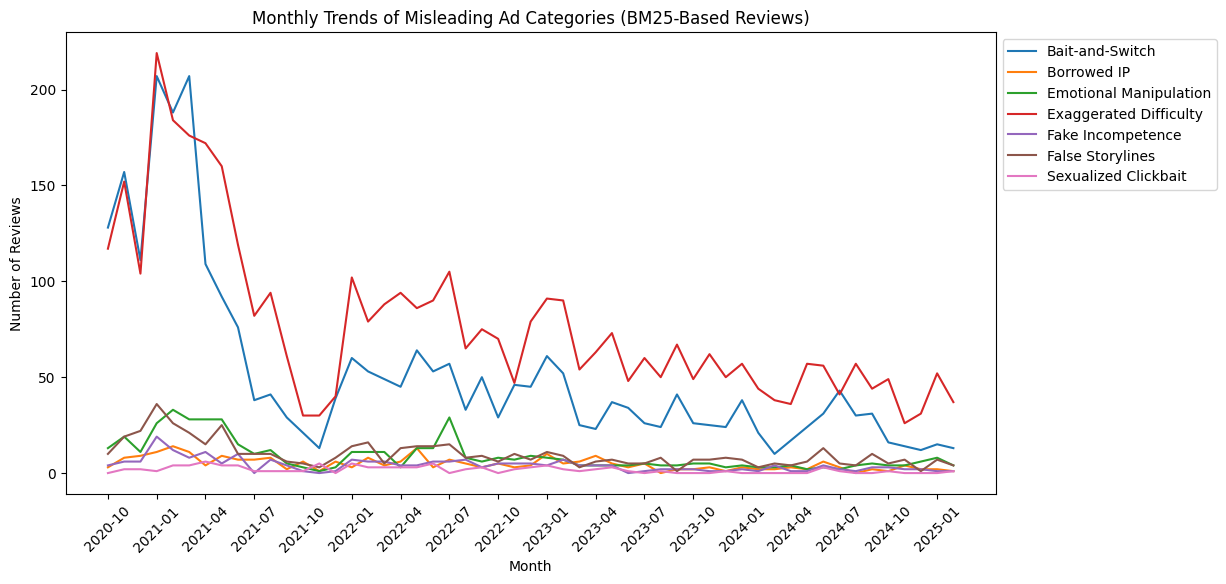

In [44]:
df = filtered_df.copy()
df['at_x'] = pd.to_datetime(df['at_x'], errors='coerce')

# Extract year and month for grouping
df['Year-Month'] = df['at_x'].dt.to_period('M')

# Count occurrences of each category per month
monthly_category_counts = df.groupby(['Year-Month', 'Category']).size().unstack(fill_value=0)

# Plot category trends over time
plt.figure(figsize=(12, 6))
for category in monthly_category_counts.columns:
    plt.plot(monthly_category_counts.index.astype(str), monthly_category_counts[category], label=category)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Trends of Misleading Ad Categories (BM25-Based Reviews)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.xticks(ticks=monthly_category_counts.index[::3].astype(str))
plt.show()

# Topic Modeling

In [ ]:
def apply_topic_modeling(df, nr_topics, text_column="content", topic_column="topic"):
    """
    Applies BERTopic modeling on a specified text column in a DataFrame.
    Allows specifying a different column name for topics to prevent overwriting.
    """

    df = df.dropna(subset=[text_column]).copy()
    docs = df[text_column].astype(str).tolist()

    # Apply BERTopic
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, nr_topics=nr_topics)
    topics, probs = topic_model.fit_transform(docs)

    # Store results in a custom column
    df[topic_column] = topics
    df[f"{topic_column}_info"] = df[topic_column].apply(
        lambda t: topic_model.topic_labels_[t] if t in topic_model.topic_labels_ else "Unknown"
    )

    # Get topic frequency
    topic_freq = topic_model.get_topic_info()

    return df, topic_freq, topic_model

In [45]:
final_df, topic_freq, topic_model = apply_topic_modeling(final_df, nr_topics=40, text_column="content", topic_column="topic")
topic_freq

2025-03-03 21:16:49,033 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1301 [00:00<?, ?it/s]

2025-03-03 21:17:00,291 - BERTopic - Embedding - Completed ✓
2025-03-03 21:17:00,292 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-03 21:17:23,013 - BERTopic - Dimensionality - Completed ✓
2025-03-03 21:17:23,015 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-03 21:37:00,585 - BERTopic - Cluster - Completed ✓
2025-03-03 21:37:00,587 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-03 21:37:01,551 - BERTopic - Representation - Completed ✓
2025-03-03 21:37:01,552 - BERTopic - Topic reduction - Reducing number of topics
2025-03-03 21:37:02,139 - BERTopic - Topic reduction - Reduced number of topics from 616 to 40
2025-03-03 21:37:02,511 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1301 [00:00<?, ?it/s]

2025-03-03 21:37:12,687 - BERTopic - Embedding - Completed ✓
2025-03-03 21:37:12,688 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-03 21:37:37,691 - BERTopic - Dimensionality - Completed ✓
2025-03-03 21:37:37,693 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-03 22:00:21,826 - BERTopic - Cluster - Completed ✓
2025-03-03 22:00:21,828 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-03 22:00:22,798 - BERTopic - Representation - Completed ✓
2025-03-03 22:00:22,800 - BERTopic - Topic reduction - Reducing number of topics
2025-03-03 22:00:23,398 - BERTopic - Topic reduction - Reduced number of topics from 620 to 40


,Topic,Count,Name,Representation,Representative_Docs
0,-1,10891,-1_the_to_and_it,"[the, to, and, it, you, game, is, of, this, but]",[i played this game in the past and got bored ...
1,0,12254,0_game_to_great_the,"[game, to, great, the, and, good, this, fun, y...","[i really like this game it's fun to play, i l..."
2,1,4225,1_fun_addictive_addicting_very,"[fun, addictive, addicting, very, boring, so, ...","[fun, fun, fun]"
3,2,3065,2_awesome_cool_nice_great,"[awesome, cool, nice, great, love, it, amazing...","[awesome, great awesome, awesome cool]"
4,3,2094,3_ads_ad_like_nothing,"[ads, ad, like, nothing, advertised, the, fals...","[not what is advertised, misleading, game is n..."
5,4,2017,4_good_far_so_bad,"[good, far, so, bad, very, pretty, not, ok, de...","[good so far, good so far, good so far]"
6,5,1601,5_my_account_to_it,"[my, account, to, it, and, phone, the, this, g...",[got a new phone and my old account was lost.....
7,6,682,6_kool_hai_gud_yg,"[kool, hai, gud, yg, iklan, lain, gr8, bagus, ...","[kool game, kool game, kool game]"
8,7,681,7_time_killer_pass_kill,"[time, killer, pass, kill, good, fun, way, was...","[good time game, fun time, fun time]"
9,8,556,8_ok_okay_its_alright,"[ok, okay, its, alright, luv, ight, aight, fin...","[ok, ok, ok]"


# Filter Ads-related Topics

In [49]:
ad_df = final_df[final_df["topic"].isin([3, 11, 12, 13, 19, 26, 38])]
ad_df, topic_freq, topic_model = apply_topic_modeling(ad_df, nr_topics=75 ,text_column="content", topic_column="topic")
topic_freq

2025-03-03 22:06:15,127 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2025-03-03 22:06:16,982 - BERTopic - Embedding - Completed ✓
2025-03-03 22:06:16,983 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-03 22:06:26,966 - BERTopic - Dimensionality - Completed ✓
2025-03-03 22:06:26,968 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-03 22:06:27,662 - BERTopic - Cluster - Completed ✓
2025-03-03 22:06:27,663 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-03 22:06:27,771 - BERTopic - Representation - Completed ✓
2025-03-03 22:06:27,772 - BERTopic - Topic reduction - Reducing number of topics
2025-03-03 22:06:27,773 - BERTopic - Topic reduction - Reduced number of topics from 73 to 73
2025-03-03 22:06:27,957 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2025-03-03 22:06:28,738 - BERTopic - Embedding - Completed ✓
2025-03-03 22:06:28,739 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-03 22:06:38,717 - BERTopic - Dimensionality - Completed ✓
2025-03-03 22:06:38,718 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-03 22:06:39,398 - BERTopic - Cluster - Completed ✓
2025-03-03 22:06:39,399 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-03 22:06:39,507 - BERTopic - Representation - Completed ✓
2025-03-03 22:06:39,508 - BERTopic - Topic reduction - Reducing number of topics
2025-03-03 22:06:39,509 - BERTopic - Topic reduction - Reduced number of topics from 72 to 72


,Topic,Count,Name,Representation,Representative_Docs
0,-1,165,-1_ads_what_showed_at,"[ads, what, showed, at, not, ad, false, the, i...","[not what is in ad, i wanna say something, whe..."
1,0,39,0_garbage_rubbish_junk_hot,"[garbage, rubbish, junk, hot, pure, absolute, ...","[garbage, garbage, garbage]"
2,1,36,1_advertised_as_not_unistalled,"[advertised, as, not, unistalled, unoriginal, ...","[not as advertised, not as advertised, not as ..."
3,2,44,2_trash_complete_bin_bloat,"[trash, complete, bin, bloat, trashhhh, dirt, ...","[trash, trash, trash]"
4,3,46,3_trash_garbage_me_poor,"[trash, garbage, me, poor, this, yap, game, de...","[this game is trash, trash game, trash game]"
...,...,...,...,...,...
67,66,33,66_different_from_same_ads,"[different, from, same, ads, as, 90, the, comp...","[different from ads, different from ads, diffe..."
68,67,16,67_described_as_ad_shown,"[described, as, ad, shown, in, discribed, alls...","[not what was described in ad, nothing as desc..."
69,68,29,68_video_shown_pictures_as,"[video, shown, pictures, as, not, shows, descr...","[not what the video shows, not as shown in the..."
70,69,49,69_false_advertising_your_advertisement,"[false, advertising, your, advertisement, adve...",[false advertising. the game is nothing like i...


In [50]:
# Visualize topic distribution
topic_model.visualize_topics()

# Classifying Misleading Ad Topics Using Sentence Transformers

In [51]:
# Load a transformer model for embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

# Load topics dataset
topics_df = topic_freq

# Extract topic descriptions from 'Representation' column
topic_descriptions = topics_df["Representation"].astype(str).tolist()

# Define predefined misleading ad categories
categories = [
    "Bait-and-Switch - fake gameplay or features not in the real game",
    "Fake Incompetence - character fails on purpose to make viewers want to try",
    "Emotional Manipulation - uses drama, urgency, or distress to get attention",
    "Sexualized Clickbait - provocative visuals, mostly women",
    "False Storylines - storytelling that does not exist in the actual game",
    "Borrowed IP - uses famous characters, brands, or styles not in the game",
    "Exaggerated Difficulty - claims the game is super hard when it's easy"
]

# Compute embeddings for topics and categories
topic_embeddings = model.encode(topic_descriptions, convert_to_tensor=True)
category_embeddings = model.encode(categories, convert_to_tensor=True)

# Compute cosine similarity between topics and categories
similarity_matrix = util.pytorch_cos_sim(topic_embeddings, category_embeddings)

# Assign each topic to the closest category
topic_to_category = {}
for i, topic in enumerate(topic_descriptions):
    best_match_idx = similarity_matrix[i].argmax().item()  # Get the best matching category index
    topic_to_category[topics_df.loc[i, "Topic"]] = categories[best_match_idx]  # Assign category

# Apply mapping to the dataset
topics_df["Category"] = topics_df["Topic"].map(topic_to_category)

topics_df

,Topic,Count,Name,Representation,Representative_Docs,Category
0,-1,165,-1_ads_what_showed_at,"[ads, what, showed, at, not, ad, false, the, i...","[not what is in ad, i wanna say something, whe...",Bait-and-Switch - fake gameplay or features no...
1,0,39,0_garbage_rubbish_junk_hot,"[garbage, rubbish, junk, hot, pure, absolute, ...","[garbage, garbage, garbage]","Sexualized Clickbait - provocative visuals, mo..."
2,1,36,1_advertised_as_not_unistalled,"[advertised, as, not, unistalled, unoriginal, ...","[not as advertised, not as advertised, not as ...","Sexualized Clickbait - provocative visuals, mo..."
3,2,44,2_trash_complete_bin_bloat,"[trash, complete, bin, bloat, trashhhh, dirt, ...","[trash, trash, trash]","Borrowed IP - uses famous characters, brands, ..."
4,3,46,3_trash_garbage_me_poor,"[trash, garbage, me, poor, this, yap, game, de...","[this game is trash, trash game, trash game]","Borrowed IP - uses famous characters, brands, ..."
...,...,...,...,...,...,...
67,66,33,66_different_from_same_ads,"[different, from, same, ads, as, 90, the, comp...","[different from ads, different from ads, diffe...",Bait-and-Switch - fake gameplay or features no...
68,67,16,67_described_as_ad_shown,"[described, as, ad, shown, in, discribed, alls...","[not what was described in ad, nothing as desc...",False Storylines - storytelling that does not ...
69,68,29,68_video_shown_pictures_as,"[video, shown, pictures, as, not, shows, descr...","[not what the video shows, not as shown in the...","Sexualized Clickbait - provocative visuals, mo..."
70,69,49,69_false_advertising_your_advertisement,"[false, advertising, your, advertisement, adve...",[false advertising. the game is nothing like i...,Bait-and-Switch - fake gameplay or features no...


In [52]:
# Load the reviews dataset
reviews_df = ad_df

# Define short category names
category_mapping = {
    "Bait-and-Switch - fake gameplay or features not in the real game": "Bait-and-Switch",
    "Fake Incompetence - character fails on purpose to make viewers want to try": "Fake Incompetence",
    "Emotional Manipulation - uses drama, urgency, or distress to get attention": "Emotional Manipulation",
    "Sexualized Clickbait - provocative visuals, mostly women": "Sexualized Clickbait",
    "False Storylines - storytelling that does not exist in the actual game": "False Storylines",
    "Borrowed IP - uses famous characters, brands, or styles not in the game": "Borrowed IP",
    "Exaggerated Difficulty - claims the game is super hard when it's easy": "Exaggerated Difficulty"
}
topics_df["Category"] = topics_df["Category"].map(category_mapping)
topic_to_category = dict(zip(topics_df["Topic"], topics_df["Category"]))
reviews_df["Category"] = reviews_df["topic"].map(topic_to_category)
reviews_df

,reviewId,at,content,Category,Query,BM25 Score,topic,topic_info
7,18cdbd1a-fd19-481b-aec8-eae0de87e9f9,2025-02-28 20:05:26,garbage fake,Sexualized Clickbait,fake game ad,7.987489,0,0_garbage_rubbish_junk_hot
9,37dfa740-171f-472d-b143-18e6b88504d7,2025-02-28 11:41:03,nothing like ad or screenshots. i just wanted ...,Bait-and-Switch,nothing like the ad,7.591197,41,41_zombies_zombie_with_to
12,ea568834-3277-44ad-b271-d2e4417ef910,2025-02-28 04:38:29,why is it so hard to find a mobile game withou...,Sexualized Clickbait,ad says it's hard but it's not,6.903004,11,11_women_female_characters_are
26,f0ae2df5-0857-42fd-ae48-796e536f42c8,2025-02-25 04:23:42,intetesting game objectifies women though,Sexualized Clickbait,women sexualized,8.333367,11,11_women_female_characters_are
30,2df33049-dd70-4f04-803a-d6e058478c01,2025-02-24 20:02:39,misleading advertisement,Sexualized Clickbait,ad was misleading,8.346565,16,16_claim_misleading_advertising_relevant
...,...,...,...,...,...,...,...,...
41597,a9379ef4-89aa-49b7-8ceb-36b97ecb8d2b,2020-10-05 13:40:04,nothing like the ad,Bait-and-Switch,nothing like the ad,14.577748,55,55_ad_nothing_like_hated
41600,c5040454-abf8-4bb4-93fd-afffcf0d38e1,2020-10-05 04:03:25,nothing like the preview. deleted ten minutes ...,Sexualized Clickbait,nothing like the ad,7.131612,45,45_preview_previews_nothing_like
41601,caef180f-2957-4248-9656-34931b19659f,2020-10-05 03:19:28,absolutely nothing like the add #bs,False Storylines,nothing like the ad,8.088699,22,22_add_nothing_like_what
41604,c5407e0d-191d-49d8-a822-2e4fb8984891,2020-10-04 20:29:01,you should be sued for false advertising,Sexualized Clickbait,bait and switch,0.000000,6,6_false_advertising_biggest_last


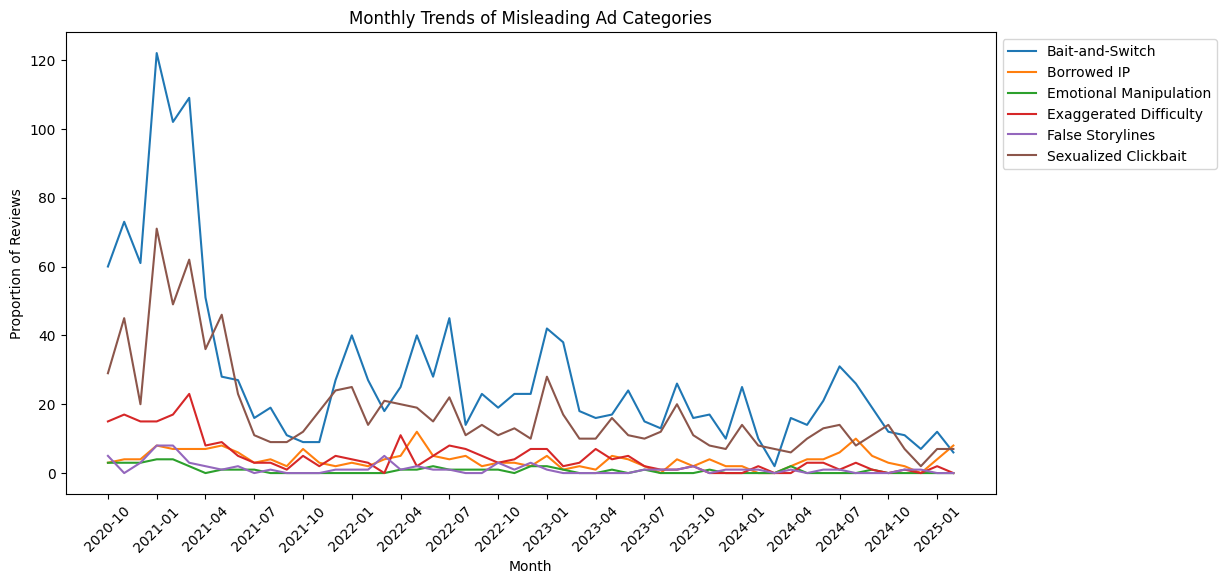

In [56]:
df = reviews_df
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df['Year-Month'] = df['at'].dt.to_period('M')
monthly_category_counts = df.groupby(['Year-Month', 'Category']).size().unstack(fill_value=0)

# Normalize by total reviews per month
monthly_category_normalized = monthly_category_counts

# Plot category trends over time
plt.figure(figsize=(12, 6))

for category in monthly_category_normalized.columns:
    plt.plot(monthly_category_normalized.index.astype(str), monthly_category_normalized[category], label=category)
plt.xlabel('Month')
plt.ylabel('Proportion of Reviews')
plt.title('Monthly Trends of Misleading Ad Categories')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.xticks(ticks=monthly_category_normalized.index[::3].astype(str))
plt.show()

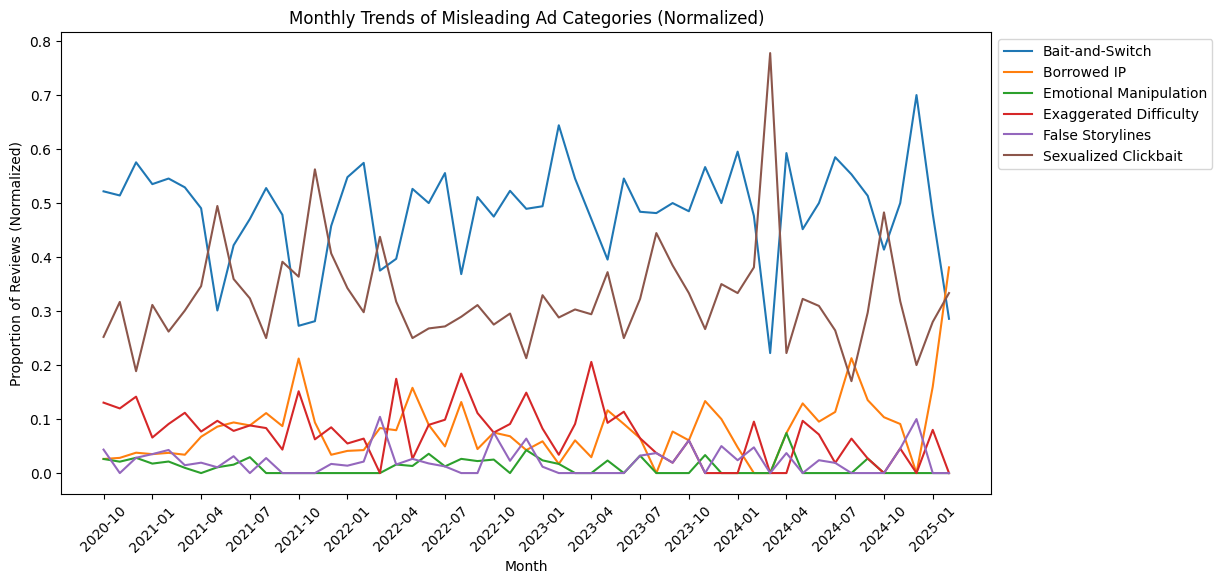

In [55]:
df = reviews_df
df['at'] = pd.to_datetime(df['at'], errors='coerce')
df['Year-Month'] = df['at'].dt.to_period('M')
monthly_category_counts = df.groupby(['Year-Month', 'Category']).size().unstack(fill_value=0)

# Normalize by total reviews per month
monthly_category_normalized = monthly_category_counts.div(monthly_category_counts.sum(axis=1), axis=0)

# Plot category trends over time
plt.figure(figsize=(12, 6))

for category in monthly_category_normalized.columns:
    plt.plot(monthly_category_normalized.index.astype(str), monthly_category_normalized[category], label=category)
plt.xlabel('Month')
plt.ylabel('Proportion of Reviews (Normalized)')
plt.title('Monthly Trends of Misleading Ad Categories (Normalized)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.xticks(ticks=monthly_category_normalized.index[::3].astype(str))
plt.show()